In [32]:
import matplotlib.pyplot as plt
import numpy as np
from finite_env import BlackjackFiniteEnv
from agent import BlackjackAgent
import math

In [33]:
# agent and env initializing
# configuration
num_episodes = 500000  # Total number of episodes to train
start_epsilon = 1.0        # Initial exploration rate
min_epsilon = 0.005   # Minimum exploration rate

# reach min_epsilon at 90% of the episodes
target_decay_episodes = num_episodes * 0.9 
epsilon_decay = (min_epsilon / start_epsilon) ** (1 / target_decay_episodes)

env = BlackjackFiniteEnv(num_decks=1)
agent = BlackjackAgent(
    alpha = 0.01,      # Learning rate
    gamma = 0.95,     # Discount factor for future hands in the deck
    epsilon = start_epsilon,
    min_epsilon = min_epsilon,
    epsilon_decay = epsilon_decay
)

stats = {"rewards": [], "epsilon": [], "hands_per_episode": []}

In [ ]:
# state def for multiple decks

def get_generalized_state(self):
    # 1. Hand Value (Same as before)
    def local_hand_value(cards):
        t = sum(cards)
        if 1 in cards and t + 10 <= 21:
            t += 10
        return t, False

    total, _ = local_hand_value(self.player_cards)
    usable_ace = (1 in self.player_cards and sum(self.player_cards) + 10 <= 21)
    
    # Normalized Depth
    decks_remaining = len(self.deck) / 52.0
    decks_bucket = round(decks_remaining * 2) / 2  # Buckets: 0, 0.5, 1.0, 1.5, ...
    
    # Normalized Count
    # True Count = Running Count / Decks Remaining
    divisor = max(0.5, decks_remaining) # Avoid division by zero
    true_count = self.running_count / divisor
    
    # Bucket the True Count to reduce state space
    if true_count >= 4: true_count_bucket = 4
    elif true_count >= 2: true_count_bucket = 2
    elif true_count >= 1: true_count_bucket = 1
    elif true_count <= -4: true_count_bucket = -4
    elif true_count <= -2: true_count_bucket = -2
    elif true_count <= -1: true_count_bucket = -1
    else: true_count_bucket = 0
    
    return (total, usable_ace, true_count_bucket, decks_bucket)

# Apply the new generalized state function
env.get_state = get_generalized_state.__get__(env, BlackjackFiniteEnv)

Environment updated with Generalized State (True Count & Decks Remaining).


In [35]:
# check for agent file update
temp_agent = BlackjackAgent()
# Check the value of a state the agent hasn't seen yet
print(f"Initial Q-Value for (12, False, 0, 50): {temp_agent.q_table[(12, False, 0, 50)]}")

Initial Q-Value for (12, False, 0, 50): [0.0, 500.0]


Training loop:
Exploration doesnt reach 0

In [36]:
# training loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_episode_reward = 0
    ep_hands = 0
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        if info.get("hand_ended"):
            ep_hands += 1
            
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward
    agent.decay_epsilon()
        
    stats["rewards"].append(total_episode_reward)
    stats["epsilon"].append(agent.epsilon)
    stats["hands_per_episode"].append(ep_hands)
    
    # Print status every 1000 episodes
    if (episode + 1) % 1000 == 0:
        # Optional: Calculate average reward of last 100 episodes for a stable metric
        recent_avg = np.mean(stats["rewards"][-100:]) if len(stats["rewards"]) >= 100 else total_episode_reward
        
        print(f"Episode {episode + 1}/{num_episodes} | "
              f"Reward (Last 100 avg): {recent_avg:.1f} | "
              f"Epsilon: {agent.epsilon:.4f} | "
              f"Hands/Deck: {ep_hands}")

Episode 1000/500000 | Reward (Last 100 avg): 3167.3 | Epsilon: 0.9883 | Hands/Deck: 26
Episode 2000/500000 | Reward (Last 100 avg): 3188.6 | Epsilon: 0.9767 | Hands/Deck: 27
Episode 3000/500000 | Reward (Last 100 avg): 3247.6 | Epsilon: 0.9653 | Hands/Deck: 22
Episode 4000/500000 | Reward (Last 100 avg): 3305.5 | Epsilon: 0.9540 | Hands/Deck: 25
Episode 5000/500000 | Reward (Last 100 avg): 3380.5 | Epsilon: 0.9428 | Hands/Deck: 28
Episode 6000/500000 | Reward (Last 100 avg): 3385.1 | Epsilon: 0.9318 | Hands/Deck: 27
Episode 7000/500000 | Reward (Last 100 avg): 3382.1 | Epsilon: 0.9209 | Hands/Deck: 28
Episode 8000/500000 | Reward (Last 100 avg): 3516.2 | Epsilon: 0.9101 | Hands/Deck: 27
Episode 9000/500000 | Reward (Last 100 avg): 3521.0 | Epsilon: 0.8995 | Hands/Deck: 26
Episode 10000/500000 | Reward (Last 100 avg): 3485.0 | Epsilon: 0.8889 | Hands/Deck: 29
Episode 11000/500000 | Reward (Last 100 avg): 3395.9 | Epsilon: 0.8785 | Hands/Deck: 30
Episode 12000/500000 | Reward (Last 100 a

In [ ]:
# Stats for the final episode
final_score = stats["rewards"][-1]
final_hands = stats["hands_per_episode"][-1]
print(f"Total accumulated score for the last episode: {final_score}")
print(f"Number of hands played in the last episode: {final_hands}")

# Stats for the highest scoring episode
best_score = max(stats["rewards"])
best_episode_idx = stats["rewards"].index(best_score)
best_hands = stats["hands_per_episode"][best_episode_idx]
print(f"\nHighest accumulated score in any episode: {best_score}")
print(f"Achieved in episode: {best_episode_idx + 1}")
print(f"Number of hands played in this episode: {best_hands}")

# plotting results
def moving_average(data, window_size=500):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
# Plot the raw rewards in the background (faint)
plt.plot(stats["rewards"], alpha=0.2, color='gray', label='Episode Reward')
# Plot the moving average (solid line)
plt.plot(moving_average(stats["rewards"], 500), color='blue', label='Moving Average (500)')
plt.xlabel('Episode')
plt.ylabel('Total Accumulated Score')
plt.title('Training Progress: Finite Deck')
plt.legend()
plt.grid(True)
plt.show()

# hands per episode
plt.figure(figsize=(12, 6))
plt.plot(moving_average(stats["hands_per_episode"], 500), color='green')
plt.xlabel('Episode')
plt.ylabel('Average Hands per Deck')
plt.title('Agent Strategy: Hands Played per Deck')
plt.grid(True)
plt.show()

Total accumulated score for the last episode: 6388
Number of hands played in the last episode: 24

Highest accumulated score in any episode: 7056
Achieved in episode: 299979
Number of hands played in this episode: 21


Evaluation Environment initialized with 6 Decks and Generalized State.
EVALUATION REPORT (6 DECKS)    
Episodes Evaluated:      1000
Average Score:           7794.27
Highest Score:           9960
Lowest Score:            4787
Score Std Dev:           612.59
Avg Hands per Deck:      92.49
Bust Rate:               68.00%
Hit vs Stick Ratio:      88.1% Hits / 11.9% Sticks


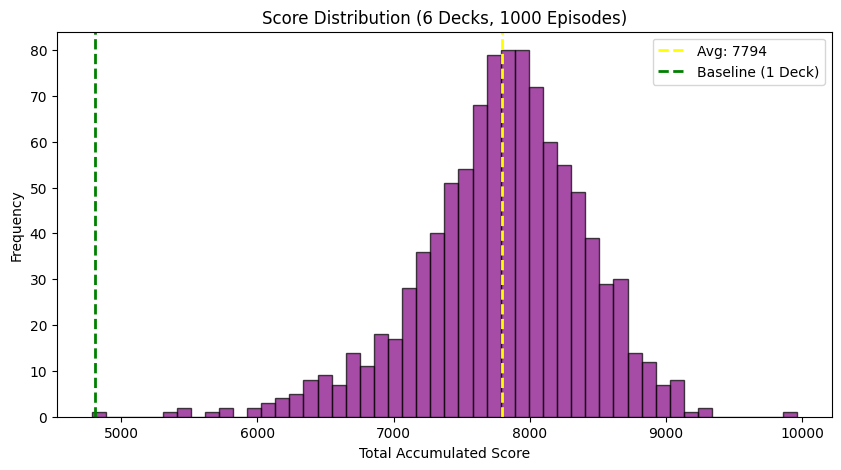

In [ ]:
# evaluation phase
EVAL_NUM_DECKS = 1
n_eval_episodes = 1000
eval_env = BlackjackFiniteEnv(num_decks=EVAL_NUM_DECKS)

# Apply Generalized State Function to Eval Env
try:
    eval_env.get_state = get_generalized_state.__get__(eval_env, BlackjackFiniteEnv)
    print(f"Evaluation Environment initialized with {EVAL_NUM_DECKS} Decks and Generalized State.")
except NameError:
    # Fallback if you haven't defined the generalized state yet
    print("WARNING: 'get_generalized_state' not found. Using default state (Training on >1 deck may fail).")


eval_stats = {
    "scores": [],
    "hands_per_episode": [],
    "total_hands": 0,
    "busts": 0,
    "hits": 0,
    "sticks": 0
}

# 0 Exploration
original_epsilon = agent.epsilon
agent.epsilon = 0.0

# eval loop
for i in range(n_eval_episodes):
    state = eval_env.reset()
    done = False
    score = 0
    h = 0
    
    while not done:
        action = agent.get_action(state)
        
        if action == 1:
            eval_stats["hits"] += 1
        else:
            eval_stats["sticks"] += 1
            
        state, reward, done, info = eval_env.step(action)
        score += reward
        
        if info.get("hand_ended"):
            h += 1
            eval_stats["total_hands"] += 1
            if info.get("bust", False):
                eval_stats["busts"] += 1
                
    eval_stats["scores"].append(score)
    eval_stats["hands_per_episode"].append(h)

# restore Epsilon
agent.epsilon = original_epsilon

# stats

avg_score = np.mean(eval_stats["scores"])
max_score = np.max(eval_stats["scores"])
min_score = np.min(eval_stats["scores"])
std_dev = np.std(eval_stats["scores"])
    
avg_hands = np.mean(eval_stats["hands_per_episode"])
bust_rate = (eval_stats["busts"] / eval_stats["total_hands"]) * 100 if eval_stats["total_hands"] > 0 else 0
total_actions = eval_stats["hits"] + eval_stats["sticks"]
hit_rate = (eval_stats["hits"] / total_actions) * 100 if total_actions > 0 else 0

# Print Report
print(f"EVALUATION REPORT ({EVAL_NUM_DECKS} DECKS)    ")
print(f"Episodes Evaluated:      {n_eval_episodes}")
print(f"Average Score:           {avg_score:.2f}")
print(f"Highest Score:           {max_score}")
print(f"Lowest Score:            {min_score}")
print(f"Score Std Dev:           {std_dev:.2f}")
print(f"Avg Hands per Deck:      {avg_hands:.2f}")
print(f"Bust Rate:               {bust_rate:.2f}%")
print(f"Hit vs Stick Ratio:      {hit_rate:.1f}% Hits / {100-hit_rate:.1f}% Sticks")


# Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(eval_stats["scores"], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(avg_score, color='yellow', linestyle='dashed', linewidth=2, label=f'Avg: {avg_score:.0f}')
plt.axvline(4811, color='green', linestyle='dashed', linewidth=2, label='Baseline (1 Deck)')
plt.title(f"Score Distribution ({EVAL_NUM_DECKS} Decks, {n_eval_episodes} Episodes)")
plt.xlabel("Total Accumulated Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [40]:
# # Evaluation (No Exploration)
# n_eval_episodes = 1000
# eval_stats = {
#     "scores": [],
#     "hands_per_episode": [],
#     "total_hands": 0,
#     "busts": 0,
#     "hits": 0,
#     "sticks": 0
# }

# original_epsilon = agent.epsilon
# agent.epsilon = 0.0

# for i in range(n_eval_episodes):
#     state = env.reset()
#     done = False
#     score = 0
#     h = 0
    
#     while not done:
#         action = agent.get_action(state)
        
#         # Track Actions (for Hit/Stick Ratio)
#         if action == 1:
#             eval_stats["hits"] += 1
#         else:
#             eval_stats["sticks"] += 1
            
#         state, reward, done, info = env.step(action)
#         score += reward
        
#         # Track Hand Outcomes (for Bust Rate & Hands per Deck)
#         if info.get("hand_ended"):
#             h += 1
#             eval_stats["total_hands"] += 1
#             if info.get("bust", False):
#                 eval_stats["busts"] += 1
                
#     # 3. Store Episode Data
#     eval_stats["scores"].append(score)
#     eval_stats["hands_per_episode"].append(h)

# # Restore Epsilon
# agent.epsilon = original_epsilon

# # Calculate Aggregates
# avg_score = np.mean(eval_stats["scores"])
# max_score = np.max(eval_stats["scores"])
# min_score = np.min(eval_stats["scores"])
# std_dev = np.std(eval_stats["scores"])

# avg_hands = np.mean(eval_stats["hands_per_episode"])
# bust_rate = (eval_stats["busts"] / eval_stats["total_hands"]) * 100 if eval_stats["total_hands"] > 0 else 0
# total_actions = eval_stats["hits"] + eval_stats["sticks"]
# hit_rate = (eval_stats["hits"] / total_actions) * 100 if total_actions > 0 else 0

# # stats
# print("\nEVALUATION REPORT")
# print(f"Episodes Evaluated:      {n_eval_episodes}")
# print(f"Average Score:           {avg_score:.2f}  (Baseline to beat: ~4800)")
# print(f"Highest Score:           {max_score}")
# print(f"Lowest Score:            {min_score}")
# print(f"Score Std Dev:           {std_dev:.2f}")
# print(f"Avg Hands per Deck:      {avg_hands:.2f}")
# print(f"Bust Rate:               {bust_rate:.2f}%")
# print(f"Hit vs Stick Ratio:      {hit_rate:.1f}% Hits / {100-hit_rate:.1f}% Sticks")

# #Score Distribution
# plt.figure(figsize=(10, 5))
# plt.hist(eval_stats["scores"], bins=50, color='purple', alpha=0.7, edgecolor='black')
# plt.axvline(avg_score, color='yellow', linestyle='dashed', linewidth=2, label=f'Avg: {avg_score:.0f}')
# plt.axvline(4811, color='green', linestyle='dashed', linewidth=2, label='Baseline (4811)')
# plt.title(f"Distribution of Scores over {n_eval_episodes} Evaluation Episodes")
# plt.xlabel("Total Accumulated Score")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()